# Problem:
Translating a color as RGB values into what a person with color vision deficiency would see, can be done by a multiplication with a matrix $M$ [[Machado et al. 2009]](https://www.inf.ufrgs.br/~oliveira/pubs_files/CVD_Simulation/CVD_Simulation.html). 
The goal in this notebook is to find the pair of colors $x, y$ that maximizes the euclidean distance between the colors in the colorspace of a person with normal color vision and minimizes the euclidean distance between the colors in the colorspace of a person with color vision deficiency. 

Maximize: $\|x - y\|$ 

Minimize: $\|Mx - My\|$ 

Constraints: $x_i \in [0, 1]$, $y_i \in [0, 1]$

Below is a solution to this optimization problem using a SLSQP solver, which minimzes the objective function $\frac{\|Mx - My\|}{\|x - y\|}$. The current problem is, that the solver is very sensitive to the initial guess.

In [141]:
import colour
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [142]:
M = colour.blindness.matrix_cvd_Machado2009('Deuteranomaly', 1)
M

array([[ 0.367322,  0.860646, -0.227968],
       [ 0.280085,  0.672501,  0.047413],
       [-0.01182 ,  0.04294 ,  0.968881]])

In [143]:
def objective_function(vars, M):
    x = vars[:3]
    y = vars[3:]

    return np.linalg.norm(M.dot(x) - M.dot(y)) / (np.linalg.norm(y - x) + 1e-15)

bounds = [(0, 1)] * 6

current_best = np.inf
for _ in range(500):

    initial_guess = np.random.rand(6)

    result = minimize(objective_function, initial_guess, args=(M), bounds=bounds, method='SLSQP', options={'ftol': 1e-10})

    if result.fun < current_best:
        print(result.fun)
        current_best = result.fun
        x = result.x[:3]
        y = result.x[3:]

x, y, np.linalg.norm(y - x), np.linalg.norm(M.dot(x) - M.dot(y))

3.43780609057e-06
2.18276535436e-06
1.19063515737e-06
4.97865971731e-07
4.94518198752e-07
4.93892080214e-07
4.93370821701e-07
4.93064467194e-07
4.93001142382e-07


(array([  1.88011759e-04,   6.43339621e-01,   5.15549040e-01]),
 array([ 0.99934324,  0.22504178,  0.54627709]),
 1.083618234474826,
 5.3422502750245481e-07)

In [144]:
intensity = np.linspace(0, 1, 10)
x_markers = []
y_markers = []
for i in intensity:
    M = colour.blindness.matrix_cvd_Machado2009('Deuteranomaly', i)
    x_new = M.dot(x)
    y_new = M.dot(y)
    x_markers.append(x_new)
    y_markers.append(y_new)
x_markers = np.array(x_markers)
y_markers = np.array(y_markers)

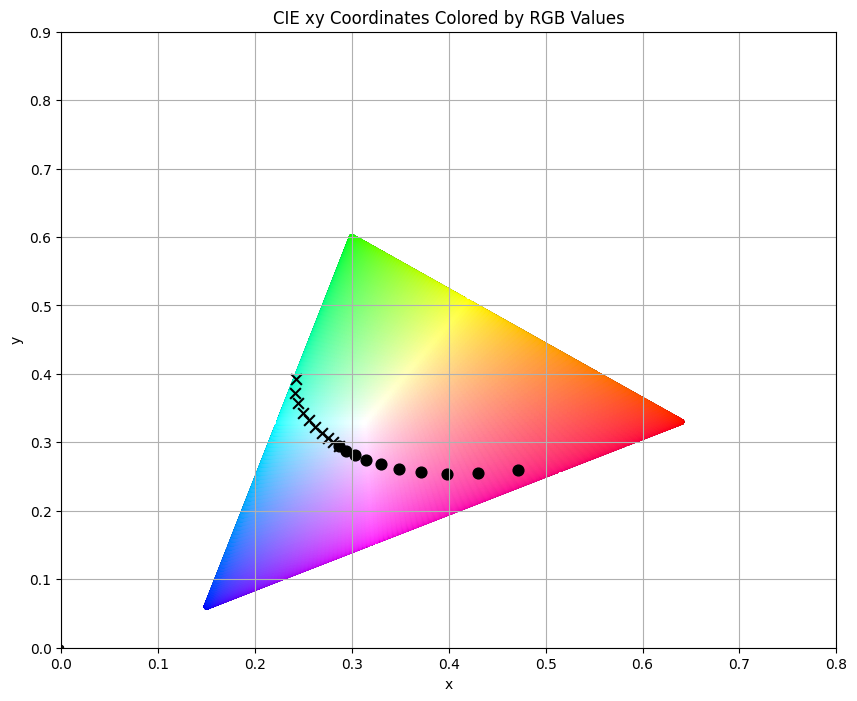

In [145]:
def create_colorspace_grid(resolution=10):
    r, g, b = np.meshgrid(np.linspace(0, 1, resolution),
                            np.linspace(0, 1, resolution),
                            np.linspace(0, 1, resolution))

    r = r.flatten()
    g = g.flatten()
    b = b.flatten()
    return np.vstack([r, g, b]).T

def rgb_to_xyz(rgb):
    rgb = rgb.copy()
    # Transformation matrix from sRGB to XYZ
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    
    # Linearize the gamma-corrected RGB values
    mask = rgb <= 0.04045
    rgb[mask] = rgb[mask] / 12.92
    rgb[~mask] = np.power((rgb[~mask] + 0.055) / 1.055, 2.4)

    # Convert to XYZ
    return np.dot(rgb, M.T)

def xyz_to_xy(xyz):
    sum_xyz = np.sum(xyz, axis=1) + 1e-15  # Adding a small constant to avoid division by zero
    x = xyz[:, 0] / sum_xyz
    y = xyz[:, 1] / sum_xyz
    return np.stack((x, y), axis=1)

def rgb_to_cie_xy(rgb_array):
    xyz_array = rgb_to_xyz(rgb_array)
    return xyz_to_xy(xyz_array)

def plot_colored_coordinates(xy_coords, rgb_values, title, x_markers=None, y_markers=None):
    plt.figure(figsize=(10, 8))
    
    plt.scatter(xy_coords[:, 0], xy_coords[:, 1], c=rgb_values, s=10)
    
    if x_markers is not None:
        xy_coords_x = rgb_to_cie_xy(x_markers)
        plt.scatter(xy_coords_x[:, 0], xy_coords_x[:, 1], c='black', s=60, marker='x')

    if y_markers is not None:
        xy_coords_y = rgb_to_cie_xy(y_markers)
        plt.scatter(xy_coords_y[:, 0], xy_coords_y[:, 1], c='black', s=60, marker='o')

    plt.xlim([0, 0.8])
    plt.ylim([0, 0.9])

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid(True)
    return plt

colorspace = create_colorspace_grid(60)
cie_xy_coords = rgb_to_cie_xy(colorspace)
plot_colored_coordinates(cie_xy_coords, colorspace, 'CIE xy Coordinates Colored by RGB Values', x_markers=x_markers, y_markers=y_markers);

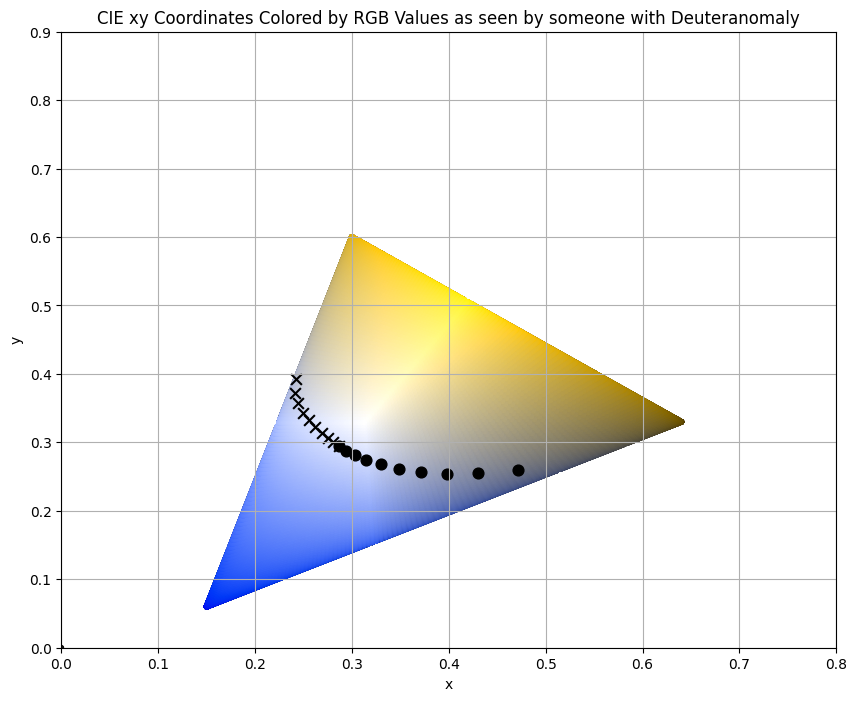

In [146]:
colors_cvd = M.dot(colorspace.T).T.clip(0,1)
plot_colored_coordinates(cie_xy_coords, colors_cvd, f'CIE xy Coordinates Colored by RGB Values as seen by someone with Deuteranomaly', x_markers=x_markers, y_markers=y_markers);